# Sales analysis with Superstore Sales Data
The data is stored in 10 separate files. The analysis attempts at compiling all data and using plotly & widgets for interactive visual creation.

## Main steps
* Compiling data files
* Analyze overall sales trend and average monthly sales
* Look into sales by market, segment, and category
* Investigate the sales per sub category in each region
* Compare the % sales contribution of the sub categories in each region against global trend
* Explore the top 10 best selling products & the most preferred shipping modes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default='svg'

1. Compile all files into one dataset

In [2]:
#Compile all files into one dataset
os.chdir('C:\\Users\\ASUS\\OneDrive\\Documents\\Programming\\Python\\practice\\Sales-Analysis-master')
 
files=[file for file in os.listdir(".\\Sales data")]

data=pd.DataFrame()
for file in files:
    df=pd.read_csv(".\\Sales data\\"+file)
    data=pd.concat([data,df])
    
data.describe()
data.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,...,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium,2011
1,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium,2011
2,HU-2011-1220,2011-01-01,2011-01-05,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,...,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High,2011
3,IT-2011-3647632,2011-01-01,2011-01-05,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,...,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High,2011
4,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium,2011


2. Investigate the overall sales trend 

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



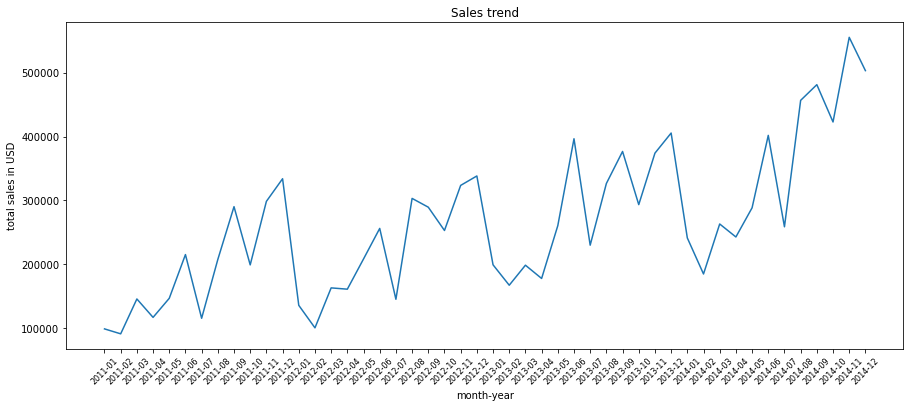

In [3]:
data['order_date']=pd.to_datetime(data.order_date)
data['order_mm_yy']=data.order_date.apply(lambda x: x.strftime('%Y-%m'))
monthly_sales=data.groupby('order_mm_yy').sales.sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(monthly_sales.order_mm_yy,
             monthly_sales.sales,
             palette=sns.color_palette("mako_r", 6))
plt.title('Sales trend')
plt.xlabel('month-year')
plt.ylabel('total sales in USD')
plt.xticks(rotation=45,size=8)
plt.show()

3. Evaluate sales by month, averaged for whole period of analysis

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



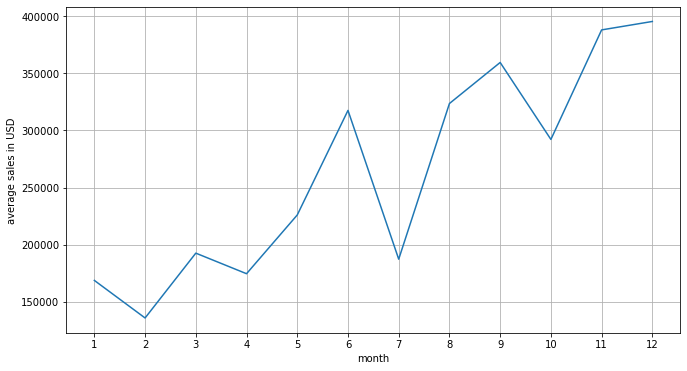

In [4]:
data['order_month']=data.order_date.dt.month

#line plot
months=[month for month, df in data.groupby('order_month')]
plt.figure(figsize = (11,6))
sns.lineplot(months, data.groupby('order_month').sales.sum()/data.order_date.dt.year.nunique())
plt.xlabel('month')
plt.ylabel('average sales in USD')
plt.xticks(months)
plt.grid()
plt.show()

4. Sales by market, segment, and category

In [5]:

#ref: https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def bar_plot(var, data):
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x=data.groupby(var).sales.sum().sort_values(ascending=False).index,
            y=data.groupby(var).sales.sum().sort_values(ascending=False).values)
    plt.title(var, size = 15)

def inter_plot(x):
    return bar_plot(x, data)

### Multiple selection widgets ###
widget_plot=widgets.Dropdown(
    options=['segment','market','category'],
    description="Numeric Variable:", 
    style = {'description_width': 'initial'}
)
interact(inter_plot, x=widget_plot);

interactive(children=(Dropdown(description='Numeric Variable:', options=('segment', 'market', 'category'), sty…

## Notes on rendering plotly graphs
The next 2 chunks of code have to be rendered in browser instead of within Jupyter Notebook as Jupyter Notebook does not support plotly interaction like selecting from a drop down menu.

5. Best selling sub categories by region

In [6]:
sales_region=data.groupby('sub_category').sales.sum().sort_values(ascending=False)

#make the general figure
fig = go.Figure(layout=go.Layout(title= go.layout.Title(text="Sales in each category by region"),
                                 xaxis=dict(title="Sub category"),
                                 yaxis=dict(title="Total sales USD")))

fig.add_trace(go.Bar(name= 'Region Selection', x= sales_region.index, y=sales_region.values))

#create button and supplement selection with corresponding data
buttons = []

buttons.append(dict(method='restyle',
                        label= 'All regions',
                        visible=True,
                        args=[{'y':[data.groupby('sub_category').sales.sum().sort_values(ascending=False)],
                               'x':[data.groupby('sub_category').sales.sum().sort_values(ascending=False).index],
                               'type':'bar'}, [0]],))
              
#use loop to add all sub categories
for i in data.region.unique():
    buttons.append(dict(method='restyle',
                        label= i,
                        visible=True,
                        args=[{'y':[data[data.region==i].groupby('sub_category').sales.sum().sort_values(ascending=False)],
                               'x':[data[data.region==i].groupby('sub_category').sales.sum().sort_values(ascending=False).index],
                               'type':'bar'}, [0]],))

#format button
updatemenus = list([
    dict(buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.05,
            xanchor="left",
            y=1.09,
            yanchor="top")])

#add dropdown menus    
fig.update_layout(showlegend=False, updatemenus=updatemenus)

fig.update_layout(
    annotations=[
        dict(text="Region", x=0.01, xref="paper", y=1.05, yref="paper",
                             align="left", showarrow=False)])

#fig.show() 
pio.show(fig,renderer='browser') ##to render on browser

6.Compare the sales contribution of the sub categories by region

In [7]:

sales_region=data.groupby('sub_category').sales.sum()/data.sales.sum()*100
sales_region.sort_values(ascending=False,inplace=True)
 
fig = go.Figure(layout=go.Layout(title= go.layout.Title(text="% Sales contribution of each category by region, compared with global data"),
                                 xaxis=dict(title="Sub category"),
                                 yaxis=dict(title="% Sales contribution")))

fig.add_trace(go.Bar(name= 'Regional', x= sales_region.index, y=sales_region.values))

#add the second series of bars to demonstrate global %
fig.add_trace(go.Bar(name= 'All Data',x= sales_region.index, y=sales_region.values))

#make button
buttons = []

buttons.append(dict(method='restyle',
                        label= 'All regions',
                        visible=True,
                        args=[{'y':[sales_region.values],
                               'x':[sales_region.index],
                               'type':'bar'}, [0]],))
              
for i in data.region.unique():
    df=data[data.region==i].groupby('sub_category').sales.sum()/data[data.region==i].sales.sum()*100
    df.sort_values(ascending=False,inplace=True)
    buttons.append(dict(method='restyle',
                        label= i,
                        visible=True,
                        args=[{'y':[df.values],
                               'x':[df.index],
                               'type':'bar'}, [0]],))

#format button
updatemenus = list([
    dict(buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.05,
            xanchor="left",
            y=1.09,
            yanchor="top")])

# add dropdown menus   
fig.update_layout(showlegend=True, updatemenus=updatemenus)

fig.update_layout(
    annotations=[
        dict(text="Region", x=0.01, xref="paper", y=1.05, yref="paper",
                             align="left", showarrow=False)])

#fig.show()
pio.show(fig,renderer='browser')

7. Top 10 products by sales value

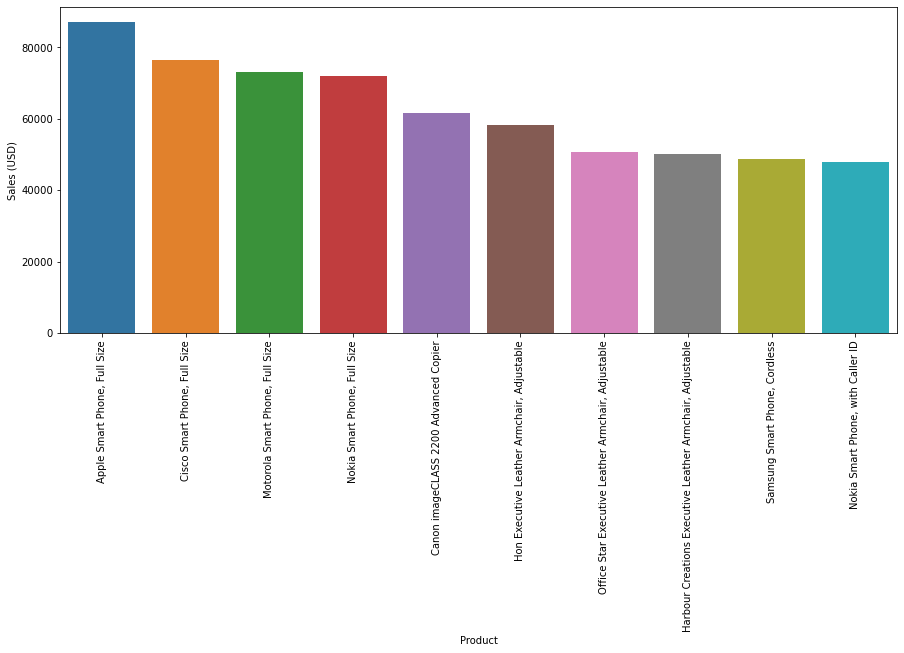

,product_name,quantity
3778,"Stanley Pencil Sharpener, Water Color",242
3779,"Smead File Cart, Single Width",250
3780,"Ibico Index Tab, Clear",251
3781,"Avery Index Tab, Clear",252
3782,"Stockwell Paper Clips, Assorted Sizes",253
3783,"Sanford Pencil Sharpener, Water Color",259
3784,"Rogers File Cart, Single Width",262
3785,"Eldon File Cart, Single Width",321
3786,"Cardinal Index Tab, Clear",337
3787,Staples,876


In [8]:
data.groupby('product_name').sales.sum().sort_values().reset_index().tail(10)

##Visualize
plt.figure(figsize=(15,6))
sns.barplot(x=data.groupby('product_name').sales.sum().sort_values(ascending=False).index[0:10],
            y=data.groupby('product_name').sales.sum().sort_values(ascending=False).values[0:10])
plt.xlabel('Product')
plt.ylabel('Sales (USD)')
plt.xticks(rotation=90)
plt.show()

#Top 10 products by sales quantity
data.groupby('product_name').quantity.sum().sort_values().reset_index().tail(10)

8. The most preferred shipping mode

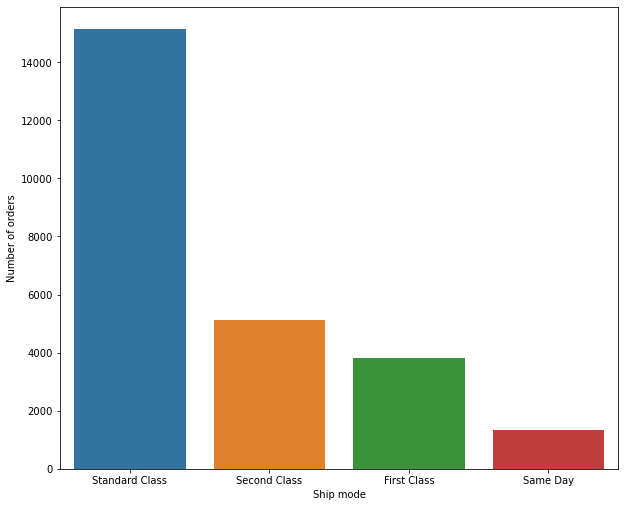

In [9]:
data.groupby('ship_mode').order_id.nunique()

#visualize
plt.figure(figsize=(10,8.5))
sns.barplot(x=data.groupby('ship_mode').order_id.nunique().sort_values(ascending=False).index,
            y=data.groupby('ship_mode').order_id.nunique().sort_values(ascending=False).values)
plt.xlabel('Ship mode')
plt.ylabel('Number of orders')
plt.show()